# Kaggle: Store Item Demand Forecasting Challenge

Kaggle [Store Item Demand Forecasting Challenge][kaggle] コンペの中の、
Kaggle Notebooks [My First Time Series Comp (Added Prophet)][adityaecdrid] を見ながら
データセットを確認します。
主に "FE" の章に書かれている基本的なデータセットの確認までを対象としています。

[kaggle]: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
[adityaecdrid]: https://www.kaggle.com/adityaecdrid/my-first-time-series-comp-added-prophet


## パッケージの追加

In [0]:
!pip install kaggle

## Import

In [0]:
# default packages
import logging
import pathlib
import re

In [0]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sklearn.model_selection as model_selection
import tqdm.notebook as tqdm

In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# graph settigns
sns.set()

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## フォルダ構成の生成

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)

## Google Drive のマウント


In [0]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

ln: failed to create symbolic link 'cache': File exists


## Kaggle API の有効化

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## データセットの読み込み

In [0]:
!kaggle competitions download -c demand-forecasting-kernels-only -p "$raw_dir"

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
df_raw = pd.read_csv(raw_dir.joinpath("train.csv.zip"), low_memory=False, parse_dates=["date"], index_col=["date"]).sort_index()
df_test = pd.read_csv(raw_dir.joinpath("test.csv"), low_memory=False, parse_dates=["date"], index_col=["date"]).sort_index()
df_subs = pd.read_csv(raw_dir.joinpath("sample_submission.csv")).sort_index()

In [0]:
display.display(df_raw.info())
display.display(df_raw.head())
display.display(df_raw.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


None

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,7,12,26
2013-01-01,7,46,27
2013-01-01,8,12,54
2013-01-01,9,12,35


,store,item,sales
date,,,
2017-12-31,9,34,21
2017-12-31,10,34,32
2017-12-31,1,35,55
2017-12-31,8,33,100
2017-12-31,10,50,82


In [0]:
display.display(df_test.info())
display.display(df_test.head())
display.display(df_test.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


None

,id,store,item
date,,,
2018-01-01,0,1,1
2018-01-01,32940,7,37
2018-01-01,3960,5,5
2018-01-01,32850,6,37
2018-01-01,32760,5,37


,id,store,item
date,,,
2018-03-31,30149,5,34
2018-03-31,30239,6,34
2018-03-31,30329,7,34
2018-03-31,30509,9,34
2018-03-31,44999,10,50


In [0]:
display.display(df_subs.info())
display.display(df_subs.head())
display.display(df_subs.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   sales   45000 non-null  int64
dtypes: int64(2)
memory usage: 703.2 KB


None

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


,id,sales
44995,44995,52
44996,44996,52
44997,44997,52
44998,44998,52
44999,44999,52


## 特徴量を追加

In [0]:
def add_datepart(df_target: pd.DataFrame) -> pd.DataFrame:
    """日付に関する情報を付与した列を追加する."""
    date_series = df_target.index.to_series()
    attr = [
        "Year",
        "Month",
        "Week",
        "Day",
        "Dayofweek",
        "Dayofyear",
        "weekofyear",
        "Is_month_end",
        "Is_month_start",
        "Is_quarter_end",
        "Is_quarter_start",
        "Is_year_end",
        "Is_year_start"
    ]
    
    df = df_target.copy()
    for name in attr: 
        df[name] = getattr(date_series.dt, name.lower())

    return df


df_datepart = add_datepart(df_raw)
display.display(df_datepart.head())

,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
date,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,7,12,26,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,7,46,27,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,8,12,54,2013,1,1,1,1,1,1,False,True,False,True,False,True
2013-01-01,9,12,35,2013,1,1,1,1,1,1,False,True,False,True,False,True


In [0]:
def extract_feature(df_target: pd.DataFrame) -> pd.DataFrame:
    """集計した特徴量とラグ特徴量を追加する.

    Notes:
        - 元の資料だとラグ特徴量の計算が上書きされていた。
        - 元の資料だとおそらく日付をシフトできていない。
            店とアイテムを分離してシフトしてから、
            シフトした値に対して集計値を算出する。
        - shift は datetimeindex の場合は、
            freq で指定することで日付を指定日だけずらせるはずなのだが、
            適切に動作しなかったので普通にスライドする。
    """
    df = df_target.copy()
    df["sales"], _ = stats.boxcox(df_target["sales"] + 1)

    df["median-store_item"] = df.groupby(["item", "store"])["sales"].transform("median")
    df["mean-store_item"] = df.groupby(["item", "store"])["sales"].transform("mean")
    df["median-month_item"] = df.groupby(["Month", "item"])["sales"].transform("median")
    df["mean-month_item"] = df.groupby(["Month", "item"])["sales"].transform("mean")
    df["median-month_store"] = df.groupby(["Month", "store"])["sales"].transform("median")

    df["median-item"] = df.groupby(["item"])["sales"].transform("median")
    df["mean-item"] = df.groupby(["item"])["sales"].transform("mean")
    df["median-store"] = df.groupby(["store"])["sales"].transform("median")
    df["mean-store"] = df.groupby(["store"])["sales"].transform("mean")

    df["median-store_item-month"] = df.groupby(["Month", "item", "store"])["sales"].transform("median")
    df["mean-store_item-week"] = df.groupby(["item", "store", "weekofyear"])["sales"].transform("mean")

    df["item-month-mean"] = df.groupby(["Month", "item"])["sales"].transform("mean")
    df["store-month-mean"] = df.groupby(["Month", "store"])["sales"].transform("mean")
    
    lags = [91, 182, 365]
    for lag in lags:
        groups = df.groupby(["item", "store"])["sales"]
        shift_sales = groups.transform(lambda x: x.shift(lag)).to_frame()
        shift_sales.columns = ["sales_shift"]
        shift_sales["item"] = df["item"]
        shift_sales["store"] = df["store"]
        shift_sales["weekofyear"] = df["weekofyear"]

        groups = shift_sales.groupby(["item", "weekofyear"])["sales_shift"]
        df[f"item-week_shifted-{lag}_sum"] = groups.transform("sum")
        df[f"item-week_shifted-{lag}_mean"] = groups.transform("mean")

        groups = shift_sales.groupby(["store", "weekofyear"])["sales_shift"]
        df[f"store-week_shifted-{lag}_sum"] = groups.transform("sum")
        df[f"store-week_shifted-{lag}_mean"] = groups.transform("mean")

    return df


%time df_feature = extract_feature(df_datepart)
display.display(df_feature.info())
display.display(df_feature.head())
display.display(df_feature.tail())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


CPU times: user 4.84 s, sys: 302 ms, total: 5.14 s
Wall time: 5.14 s
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 41 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   store                        913000 non-null  int64  
 1   item                         913000 non-null  int64  
 2   sales                        913000 non-null  float64
 3   Year                         913000 non-null  int64  
 4   Month                        913000 non-null  int64  
 5   Week                         913000 non-null  int64  
 6   Day                          913000 non-null  int64  
 7   Dayofweek                    913000 non-null  int64  
 8   Dayofyear                    913000 non-null  int64  
 9   weekofyear                   913000 non-null  int64  
 10  Is_month_end                 913000 non-null  bool   
 11  Is_month_start               913

None

,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,3.801856,2013,1,1,1,1,1,1,False,True,False,True,False,True,4.547618,4.563556,3.940734,3.955555,5.642877,4.758968,4.740214,6.526006,6.452365,3.801856,3.880016,3.955555,5.515308,1306.111474,4.664684,8909.597024,6.363998,1478.217286,5.279347,9893.455493,7.066754,1019.809435,3.922344,7099.694171,5.461303
2013-01-01,7,12,5.231329,2013,1,1,1,1,1,1,False,True,False,True,False,True,6.759170,6.705919,6.644420,6.621174,4.956572,7.706454,7.692399,5.867428,5.783121,5.794214,5.831136,6.621174,4.912584,2132.950181,7.617679,7991.150160,5.707964,2361.248876,8.433032,8892.803802,6.352003,1702.263982,6.547169,6310.303034,4.854079
2013-01-01,7,46,5.317890,2013,1,1,1,1,1,1,False,True,False,True,False,True,6.276995,6.244529,6.211956,6.189439,4.956572,7.186271,7.191242,5.867428,5.783121,5.317890,5.447337,6.189439,4.912584,1977.852076,7.063757,7991.150160,5.707964,2210.147678,7.893385,8892.803802,6.352003,1595.107388,6.135028,6310.303034,4.854079
2013-01-01,8,12,7.083867,2013,1,1,1,1,1,1,False,True,False,True,False,True,8.399611,8.375824,6.644420,6.621174,6.403639,7.706454,7.692399,7.383371,7.294623,7.186271,7.280179,6.621174,6.278610,2132.950181,7.617679,10092.698519,7.209070,2361.248876,8.433032,11154.808590,7.967720,1702.263982,6.547169,8056.238622,6.197107
2013-01-01,9,12,5.939114,2013,1,1,1,1,1,1,False,True,False,True,False,True,7.922480,7.896427,6.644420,6.621174,6.009345,7.706454,7.692399,6.924979,6.863368,6.815253,6.853381,6.621174,5.883437,2132.950181,7.617679,9484.569459,6.774692,2361.248876,8.433032,10522.892746,7.516352,1702.263982,6.547169,7554.416675,5.811090


,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31,9,34,4.758968,2017,12,52,31,6,365,52,True,False,True,False,True,False,5.317890,5.239796,4.547618,4.484947,6.276995,5.142367,5.091396,6.924979,6.863368,4.655151,4.495227,4.484947,6.139205,1836.909337,5.248312,12304.148707,7.030942,1938.659567,5.539027,13074.038653,7.470879,1236.354596,4.415552,8463.019457,6.045014
2017-12-31,10,34,5.719392,2017,12,52,31,6,365,52,True,False,True,False,True,False,5.402198,5.385276,4.547618,4.484947,6.403639,5.142367,5.091396,7.083867,7.043100,4.758968,4.720760,4.484947,6.310133,1836.909337,5.248312,12626.243415,7.214996,1938.659567,5.539027,13368.057898,7.638890,1236.354596,4.415552,8737.609958,6.241150
2017-12-31,1,35,7.135407,2017,12,52,31,6,365,52,True,False,True,False,True,False,7.286054,7.277044,6.759170,6.754168,5.867428,7.525021,7.525416,6.526006,6.452365,6.585688,6.616938,6.754168,5.765611,2689.466309,7.684189,11576.457537,6.615119,2863.496723,8.181419,12270.142943,7.011510,1874.710244,6.695394,7957.934522,5.684239
2017-12-31,8,33,8.963785,2017,12,52,31,6,365,52,True,False,True,False,True,False,8.418341,8.363046,6.978676,6.914720,6.644420,7.706454,7.689150,7.383371,7.294623,7.525021,7.418867,6.914720,6.545335,2752.946468,7.865561,13040.551250,7.451744,2917.571306,8.335918,13868.293693,7.924739,1911.585241,6.827090,9049.644048,6.464031
2017-12-31,10,50,8.323704,2017,12,52,31,6,365,52,True,False,True,False,True,False,7.964366,7.923644,6.759170,6.759743,6.403639,7.525021,7.529475,7.083867,7.043100,7.186271,7.136659,6.759743,6.310133,2701.695834,7.719131,12626.243415,7.214996,2858.823212,8.168066,13368.057898,7.638890,1865.410456,6.662180,8737.609958,6.241150


In [0]:
def set_test_feature(source: pd.DataFrame, df_target: pd.DataFrame) -> pd.DataFrame:
    target = df_target.copy()
    columns = set(source.columns) - set(df_target.columns)
    for column in columns:
        target[column] = None

    source_group = source.groupby(["store", "item", "weekofyear"]).agg("median")
    for key in tqdm.tqdm(source_group.index):
        target_index = (target["store"] == key[0]) \
            & (target["item"] == key[1]) \
            & (target["weekofyear"] == key[2])
        for column in columns:
            target.loc[target_index, column] = source_group.loc[key, column]

    return target

%time df_test_feature = set_test_feature(df_feature, add_datepart(df_test))


CPU times: user 34min 55s, sys: 19.5 s, total: 35min 14s
Wall time: 35min 8s


## LightGBM を利用した特徴量重要度の確認

In [0]:
def train_gbm(df_train: pd.DataFrame, df_test_x: pd.DataFrame):
    train_y = df_train["sales"]
    train_x = df_train.reset_index().drop(["date", "sales"], axis=1)
    test_x = df_test_x.reset_index().drop(["date", "sales", "id"], axis=1)

    logger.info(train_x.info())

    params = {
        "nthread": 4,
        "boosting_type": "gbdt",
        "objective": "regression_l1",
        "metric": "mape",
        "num_leaves": 127,
        "learning_rate": 0.25,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "lambda_l1": 0.06,
        "lambda_l2": 0.1,
        "verbose": -1,
    }

    oof_preds = np.zeros([train_y.shape[0]])
    feature_importance = {}
    folds = model_selection.KFold(n_splits=3, shuffle=True, random_state=0)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_x)):
        x, y = train_x.iloc[train_idx], train_y.iloc[train_idx]
        valid_x, valid_y = train_x.iloc[valid_idx], train_y.iloc[valid_idx]
        lgb_train = lgb.Dataset(x, y)
        lgb_valid = lgb.Dataset(valid_x, valid_y)

        gbm = lgb.train(
            params,
            lgb_train,
            1000,
            valid_sets=[lgb_train, lgb_valid],
            early_stopping_rounds=100,
            verbose_eval=100
        )
        oof_preds[valid_idx] = gbm.predict(valid_x, num_iteration=gbm.best_iteration)
        feature_importance[n_fold] = gbm.feature_importance()

    e = 2 * abs(train_y - oof_preds) / (abs(train_y) + abs(oof_preds))
    e = e.mean()
    logger.info(f"Full validation score With Box Cox {e:.4f}")

    importance = pd.DataFrame(feature_importance).T
    importance.columns = train_x.columns

    return gbm, importance


%time gbm, feature_importance = train_gbm(df_feature, df_test_feature)

INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   store                        913000 non-null  int64  
 1   item                         913000 non-null  int64  
 2   Year                         913000 non-null  int64  
 3   Month                        913000 non-null  int64  
 4   Week                         913000 non-null  int64  
 5   Day                          913000 non-null  int64  
 6   Dayofweek                    913000 non-null  int64  
 7   Dayofyear                    913000 non-null  int64  
 8   weekofyear                   913000 non-null  int64  
 9   Is_month_end                 913000 non-null  bool   
 10  Is_month_start               913000 non-null  bool   
 11  Is_quarter_end               913000 non-null  bool   
 12  Is_quarter_start             913000 non-null  bool   
 13 

INFO:__main__:Full validation score With Box Cox 0.0525


CPU times: user 1min 46s, sys: 7.07 s, total: 1min 53s
Wall time: 1min 7s


In [0]:
display.display(feature_importance.head())

,store,item,Year,Month,Week,Day,Dayofweek,Dayofyear,weekofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,median-store_item,mean-store_item,median-month_item,mean-month_item,median-month_store,median-item,mean-item,median-store,mean-store,median-store_item-month,mean-store_item-week,item-month-mean,store-month-mean,item-week_shifted-91_sum,item-week_shifted-91_mean,store-week_shifted-91_sum,store-week_shifted-91_mean,item-week_shifted-182_sum,item-week_shifted-182_mean,store-week_shifted-182_sum,store-week_shifted-182_mean,item-week_shifted-365_sum,item-week_shifted-365_mean,store-week_shifted-365_sum,store-week_shifted-365_mean
0,30,97,507,32,70,234,625,162,3,16,2,5,7,1,2,51,80,49,67,45,10,26,5,8,592,758,7,61,93,60,94,35,67,93,73,72,80,69,92,30
1,30,90,510,39,68,205,619,167,12,7,3,7,6,0,1,47,93,46,67,35,5,30,6,5,603,717,10,52,72,55,83,47,59,95,65,71,84,47,109,17
2,54,145,565,40,99,334,700,216,4,13,7,4,6,0,1,65,127,53,116,59,10,47,10,8,687,847,10,59,106,85,133,78,100,86,106,104,102,79,122,31


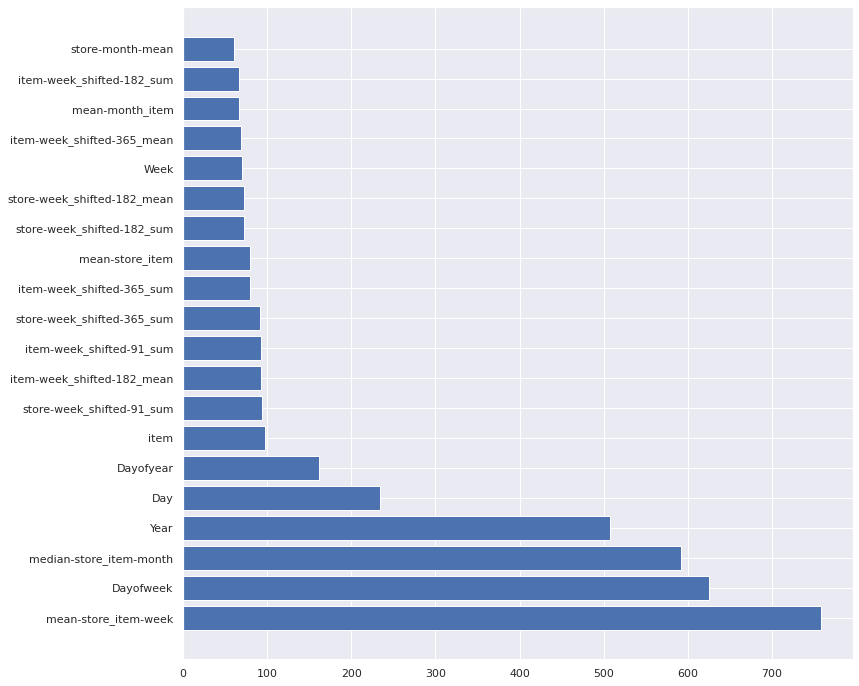

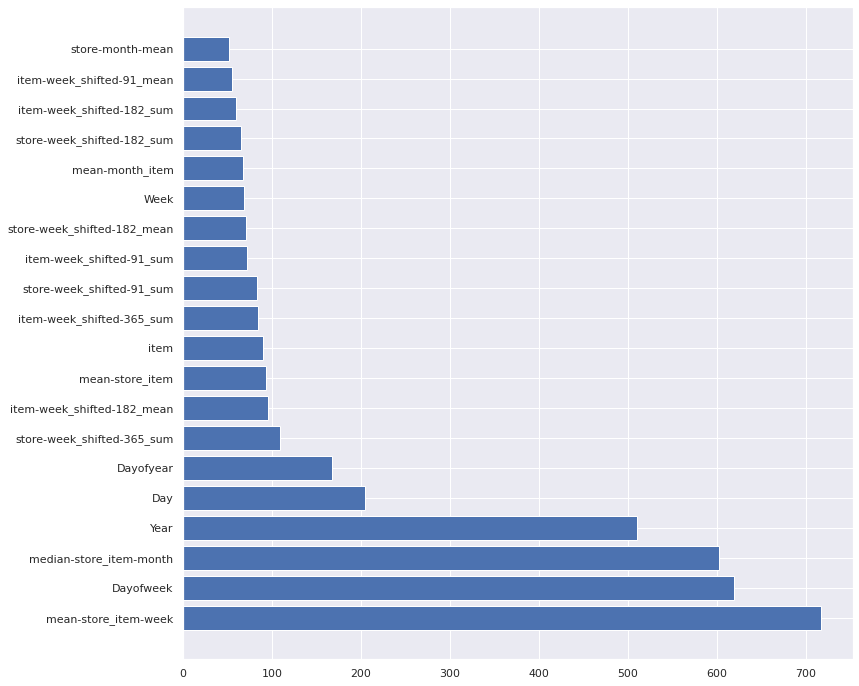

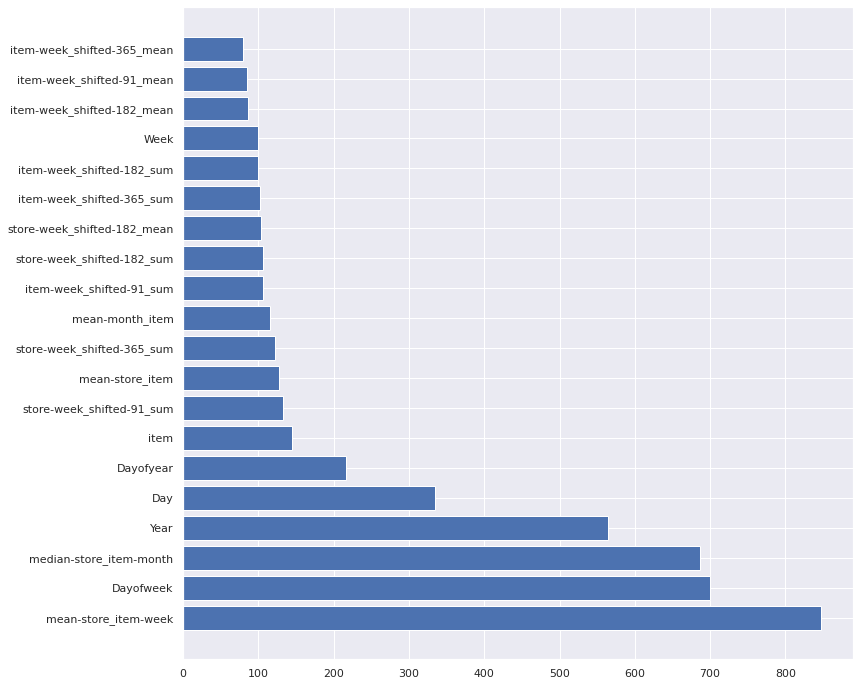

In [0]:
def plot_feature_importance(importance: pd.DataFrame, idx: int) -> None:
    df = pd.DataFrame({
        "feature": importance.columns.to_list(),
        "score": importance.iloc[idx].to_list(),
    })
    df = df.sort_values(by=["score"], ascending=False)

    top = 20
    plt.figure(figsize=(12, 12))
    plt.barh(df["feature"].iloc[:top], df["score"].iloc[:top])
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


for idx in range(len(feature_importance)):
    plot_feature_importance(feature_importance, idx)

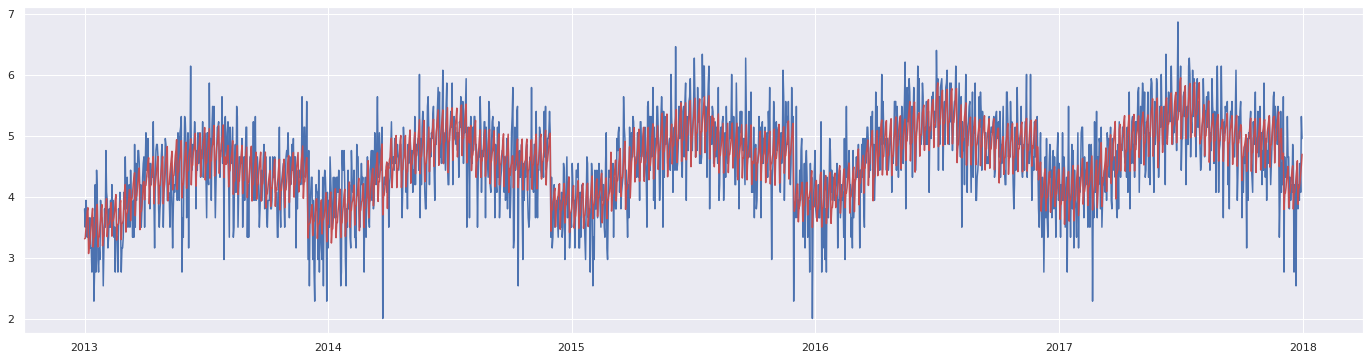

In [0]:
def plot_error(df_target: pd.DataFrame, gbm_target: lgb.LGBMModel) -> None:
    y = df_target["sales"]
    x = df_target.reset_index().drop(["date", "sales"], axis=1)

    pred = gbm.predict(x, num_iteration=gbm_target.best_iteration)

    df = pd.DataFrame({
        "store": df_target["store"],
        "item": df_target["item"],
        "sales": y,
        "pred": pred,
    })
    df_group = df.groupby(["store", "item"])
    for key, group in df_group:
        plt.figure(figsize=(24, 6))
        plt.plot(group.index, group["sales"], color="b")
        plt.plot(group.index, group["pred"], color="r")
        plt.show()
        plt.cla()
        plt.clf()
        plt.close()
        break


plot_error(df_feature, gbm)

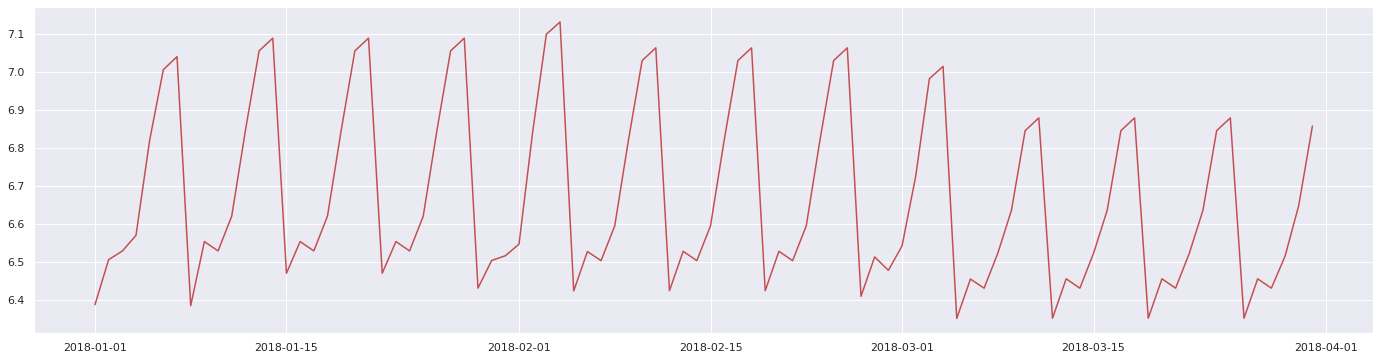

In [40]:
def plot_pred(df_target: pd.DataFrame, gbm_target: lgb.LGBMModel) -> None:
    df = df_target.copy()
    for idx in range(16, len(df.columns)):
        df[df.columns[idx]] = df[df.columns[idx]].astype(float)
    x = df.reset_index().drop(["date", "sales", "id"], axis=1)

    pred = gbm.predict(x, num_iteration=gbm_target.best_iteration)

    df = pd.DataFrame({
        "store": df["store"],
        "item": df["item"],
        "pred": pred,
    })
    df_group = df.groupby(["store", "item"])
    for key, group in df_group:
        plt.figure(figsize=(24, 6))
        plt.plot(group.index, group["pred"], color="r")
        plt.show()
        plt.cla()
        plt.clf()
        plt.close()
        break


plot_pred(df_test_feature, gbm)